# Reproducing the models of Spitoni et al. (2024)

In [8]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import vice
import paths

In [2]:
output_dir = paths.data / 'onezone' / 'Spitoni2024'
output_dir.mkdir(parents=True, exist_ok=True)

## Model Parameters

Simulation time

In [42]:
dt = 0.01
tmax = 12.5
simtime = np.arange(0, tmax+dt, dt)

Yields: I can't find a simple table of net yields for this study or any other using the same prescriptions, so I will assume the same yields as in Johnson et al. (2021).

In [4]:
from multizone.src.yields import J21

SN Ia DTD: I think they use a SD model similar to Greggio (2005)

In [15]:
from multizone.src.dtds import greggio05_single
SD_RIa = greggio05_single()

The Two-Infall Model

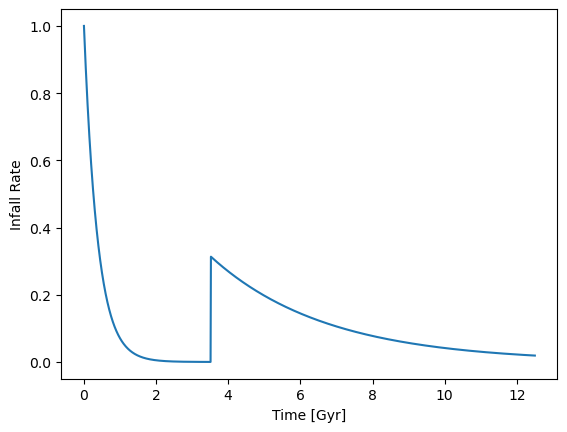

In [13]:
from multizone.src.models.normalize import twoinfall_ampratio

class OneInfall:
    def __init__(self, timescale=1, amplitude=1):
        self.timescale = timescale
        self.amplitude = amplitude
        
    def __call__(self, time):
        return self.amplitude * m.exp(-time / self.timescale)

class TwoInfall(OneInfall):
    def __init__(self, timescale1=0.377, timescale2=3.203, amplitude1=1, onset=3.519, present_mass_ratio=2.5, tmax=12.5):
        self.onset = onset
        # Calculate the amplitude ratio (second infall to first)
        amp_ratio = present_mass_ratio 
        amp_ratio *= timescale1 * (1 - m.exp(-tmax/timescale1))
        amp_ratio *= 1 / (timescale2 * (1 - m.exp(-(tmax - onset)/timescale2)))
        self.infall1 = OneInfall(timescale=timescale1, amplitude=amplitude1)
        self.infall2 = OneInfall(timescale=timescale2, amplitude=amp_ratio*amplitude1)
    
    def __call__(self, time):
        if time < self.onset:
            return self.infall1(time)
        else:
            return self.infall1(time) + self.infall2(time - self.onset)

fig, ax = plt.subplots()
twoinfall_ifr = TwoInfall()
ifr_data = np.array([twoinfall_ifr(t) for t in simtime])
ax.plot(simtime, ifr_data)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('Infall Rate')
plt.show()

The massive dwarf galaxy model

In [79]:
# As in Vincenzo et al. (2019), normalize infall to accrete a total of 10^10 Msun
dwarf_ifr = OneInfall(timescale=0.24, amplitude=(1e10/1e9)/0.24) # convert to Msun/yr
dwarf_simtime = np.arange(0, 3.51, 0.01)

dwarf = vice.singlezone(
    name=str(output_dir / 'dwarf'),
    func=dwarf_ifr,
    mode='ifr',
    elements=('fe', 'o'),
    eta=1.5,
    delay=0.04,
    RIa=SD_RIa,
    Mg0=0,
    tau_star=1/0.42,
    dt=dt,
    schmidt=True,
    # schmidt_index=1.5,
    MgSchmidt=1e10
)
dwarf.run(dwarf_simtime, overwrite=True)

In [80]:
dwarf_hist = vice.history(str(output_dir / 'dwarf'))
dwarf_hist

vice.dataframe{
    time -----------> [0, 0.01, 0.02, ... , 3.49, 3.5, 3.51]
    mgas -----------> [1e-12, 4.16667e+08, 8.1547e+08, ... , 1.80017e+09, 1.79397e+09, 1.78781e+09]
    mstar ----------> [0, 3.79776e-26, 323006, ... , 2.48571e+09, 2.4871e+09, 2.48847e+09]
    sfr ------------> [4.2e-33, 0.0357217, 0.0978051, ... , 0.320789, 0.319134, 0.317491]
    ifr ------------> [41.6667, 39.9662, 38.3352, ... , 2.01569e-05, 1.93343e-05, 1.85452e-05]
    ofr ------------> [6.3e-33, 0.0535826, 0.146708, ... , 0.481184, 0.478701, 0.476236]
    eta_0 ----------> [1.5, 1.5, 1.5, ... , 1.5, 1.5, 1.5]
    r_eff ----------> [0.0957713, 0.0957713, 0.113543, ... , 0.567851, 0.568502, 0.569152]
    z_in(fe) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(o) --------> [0, 0, 0, ... , 0, 0, 0]
    z_out(fe) ------> [0, 5.04e-17, 1.02879e-06, ... , 0.00269971, 0.00270835, 0.00271697]
    z_out(o) -------> [0, 6.3e-16, 1.28598e-05, ... , 0.0118222, 0.0118458, 0.0118694]
    mass(fe) -------> [0, 5.04e-29, 

In [81]:
# Disk evolution start time
tdisk = 1.3
dwarf_hist['[fe/h]'][int(tdisk*100)]

-0.27665109464902543

(-3.0, 0.5)

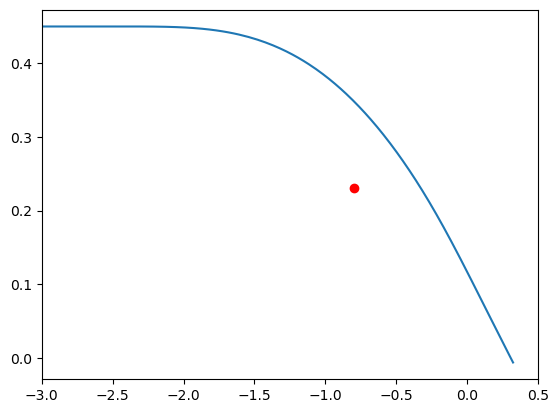

In [82]:
plt.plot(dwarf_hist['[fe/h]'], dwarf_hist['[o/fe]'])
plt.plot(-0.8, 0.23, 'ro')
plt.xlim((-3, 0.5))

In [83]:
dwarf_mdf = vice.mdf(str(output_dir / 'dwarf'))
dwarf_mdf

vice.dataframe{
    bin_edge_left --> [-3, -2.95, -2.9, ... , 0.85, 0.9, 0.95]
    bin_edge_right -> [-2.95, -2.9, -2.85, ... , 0.9, 0.95, 1]
    dn/d[fe/h] -----> [0.00878457, 0, 0, ... , 0, 0, 0]
    dn/d[o/h] ------> [0, 0.00494155, 0, ... , 0, 0, 0]
    dn/d[o/fe] -----> [0, 0, 0, ... , 0, 0, 0]
}

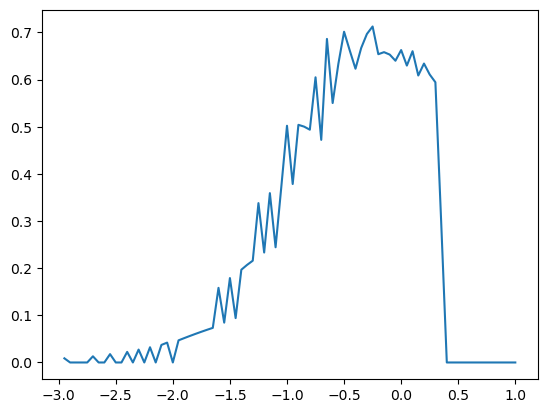

In [84]:
plt.plot(dwarf_mdf['bin_edge_right'], dwarf_mdf['dn/d[fe/h]'])
plt.show()